In [14]:
'''
These are the important imports and functions used in the detection part of the project
assuming the other libraries are already installed and imported like cv2, numpy, etc.
'''
# import albumentations as albu
from fastai.vision.all import *
from fastai.metrics import accuracy
from fastseg import MobileV3Small
import torch
import cv2
import numpy as np

In [49]:

# The functions needed for the detection part
def get_pred_for_mobilenet(model, img_array): # this is to make sure that the model is in the GPU
    with torch.no_grad():
        # image_tensor = np.expand_dims(img_array, -1).transpose(2, 0, 1).astype('float32') / 255
        image_tensor = img_array.transpose(2, 0, 1).astype('float32') / 255
        x_tensor = torch.from_numpy(image_tensor).to("cuda").unsqueeze(0)
        model_output = F.softmax(model.forward(x_tensor), dim=1).cpu().numpy()
    return model_output

def extract_lane_boundaries(left_mask, right_mask, threshold=0.3):
    left_boundary = (left_mask > threshold).astype(np.uint8)
    right_boundary = (right_mask > threshold).astype(np.uint8)

    contours, _ = cv2.findContours(left_boundary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        left_boundary = cv2.drawContours(left_boundary, contours, -1, (1), thickness=cv2.FILLED)

    contours, _ = cv2.findContours(right_boundary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        right_boundary = cv2.drawContours(right_boundary, contours, -1, (1), thickness=cv2.FILLED)

    return left_boundary, right_boundary

def lane_detection_pipeline(img, model_path="seg_model.pth"):
    # Load the model
    model = torch.load(model_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Get predictions
    back, left, right = get_pred_for_mobilenet(model, img)[0]

    # Extract left and right boundaries
    left_boundary, right_boundary = extract_lane_boundaries(left, right)

    # Create ROI mask
    # roi_mask = (left_boundary | right_boundary).astype(np.uint8)

    # # Create a copy of the original image
    # image_with_roi = np.copy(img)

    # # Set all pixels outside the ROI to black
    # image_with_roi[roi_mask == 0] = [0, 0, 0]

    # # Overlay the left and right lane boundaries in red color
    # image_with_roi[left_boundary > 0] = [255, 0, 0]
    # image_with_roi[right_boundary > 0] = [0, 255, 0]

    # Find the coordinates of the left and right boundaries
    left_y, left_x = np.where(left_boundary > 0)
    right_y, right_x = np.where(right_boundary > 0)

    # Create a black background mask with the same dimensions as the image
    mask = np.zeros_like(img, dtype=np.uint8)

    # Create a polygon for the left boundary
    left_polygon = np.column_stack((left_x, left_y))

    # Create a polygon for the right boundary (reverse the order to close the gap)
    right_polygon = np.column_stack((right_x[::-1], right_y[::-1]))

    # Combine the left and right polygons to fill the region between them
    polygon_points = np.vstack((left_polygon, right_polygon))

    # Use fillPoly to fill the region between the left and right boundaries
    try:
        cv2.fillPoly(mask, [polygon_points], (255, 255, 255))
    except Exception as e:
        print(f"Error in cv2.fillPoly: {e}")
        return None

    # Bitwise-AND your original image and the mask
    result = cv2.bitwise_and(img, mask)

    # Save the resulting image
    # cv2.imwrite(save_path, result)
    return back, left, right

    # return result


In [57]:
def show_imgs(imgs, titles):
    rows = int(np.ceil(len(imgs) / 3 ))
    cols = 3
    figsize = (cols * 5, rows * 4)
    _, axs = plt.subplots(rows, cols, figsize=figsize)
    for img, title, ax in zip(imgs, titles, axs.flatten()):
        ax.imshow(img, cmap="gray")
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

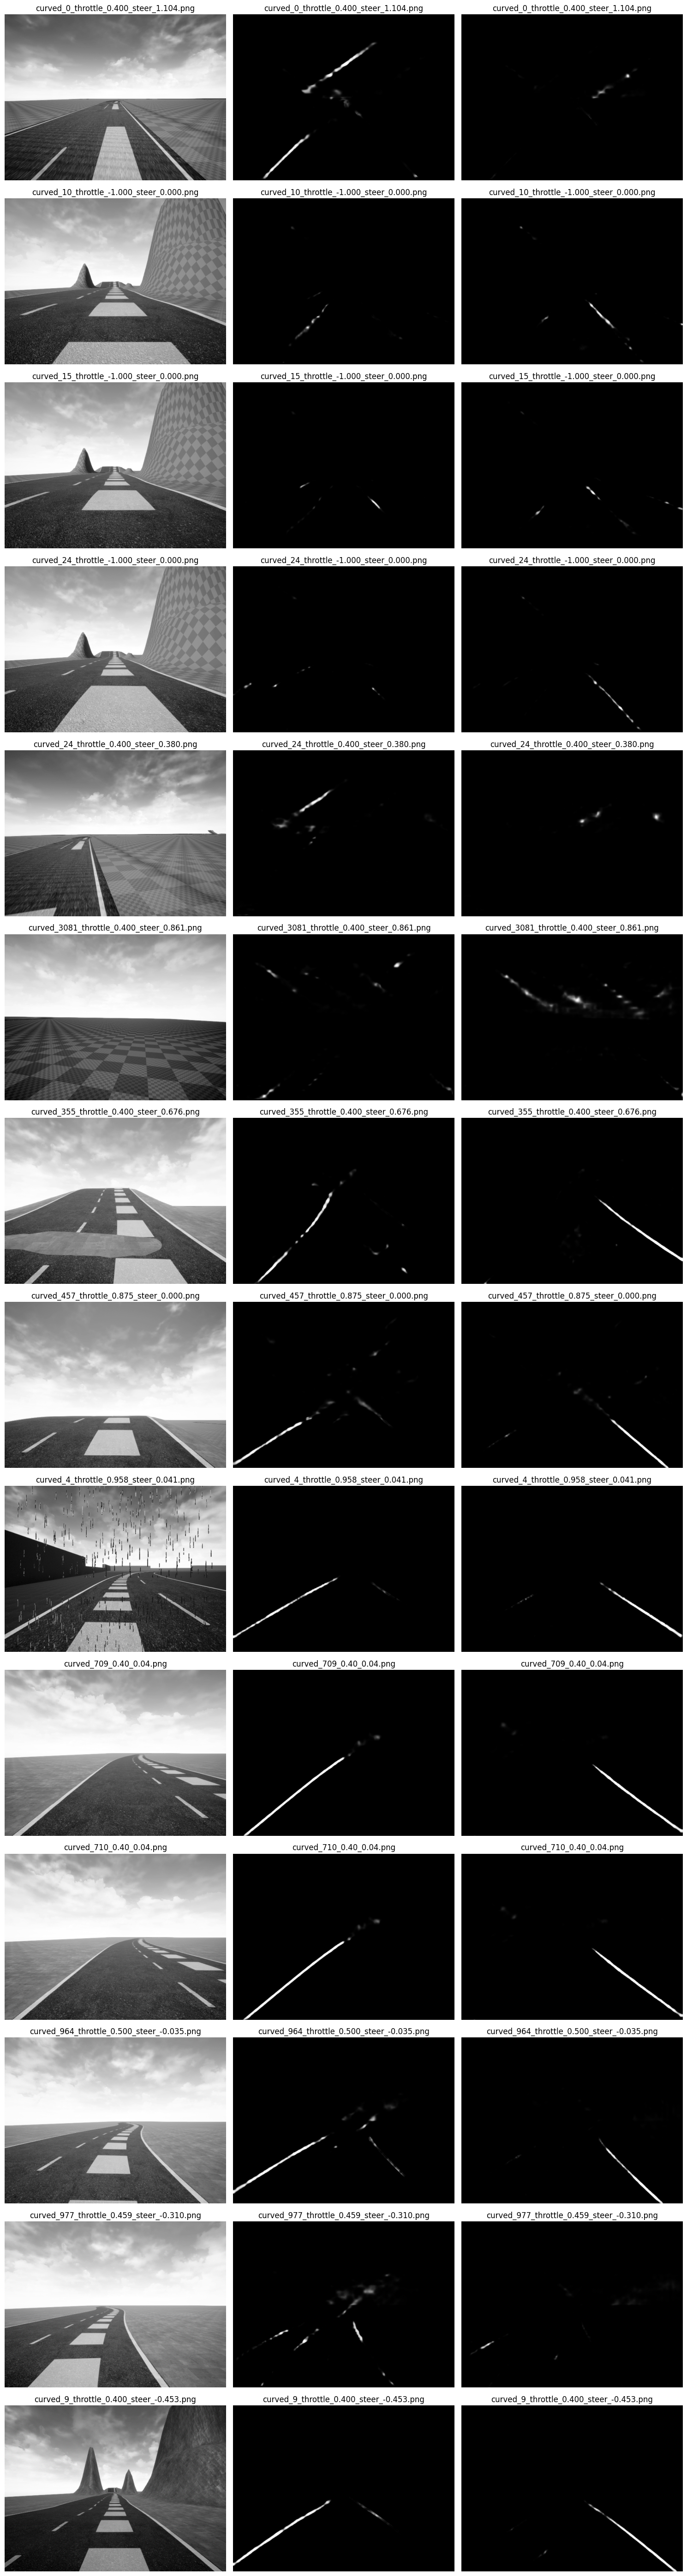

In [58]:
# %%timeit
folder = "imgs_edge_cases/new_env_small"
images = []
titles = []

for img_name in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, img_name), cv2.IMREAD_GRAYSCALE)
    back, left, right = lane_detection_pipeline(img)
    images.extend([img, left, right])
    titles.extend([img_name, img_name, img_name])

show_imgs(images, titles)